# Сфера v2.0

Решение упругопластической задачи в напряжениях для деформируемой толстостенной сферы.

Обозначение начального момента времени (для тестов)

In [1]:
import time
start_time = time.time()

## 1. График функции пластичности в координатах $(σ_{r}, σ_{t})$

Необходимые импорты

In [2]:
import math
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
from scipy.optimize import root
plt.rcParams["figure.figsize"] = (5, 5)  # общий размер для всех графиков

Константы

In [3]:
a = 0.2
b = 1
k = 1
η = np.sqrt(6)
σ = 1
w = 2

Задание функции пластичности $f(σ_{r}, σ_{t})$ и символьных переменных $σ_{r}, σ_{t}$

In [4]:
σr, σt = sy.symbols('sigma_r, sigma_t', real=True)

def f(σr, σt):
    return (σ * (σr**w + 2 * σt**w)**(1/w)
     + η * abs(σr - σt)) / (k * (η + σ)) - 1
    
# Вывести функцию пластичности
display(sy.Eq(sy.Function("f")(σr, σt), f(σr, σt)))

Eq(f(sigma_r, sigma_t), 0.289897948556636*(sigma_r**2 + 2*sigma_t**2)**0.5 + 0.710102051443364*Abs(sigma_r - sigma_t) - 1)

Найдём минимальное и максимальное значение напряжений $σ_{r}$ и $σ_{t}$ (нужно для вычислений и построения графиков)

Предварительная оценка предельных значений напряжений

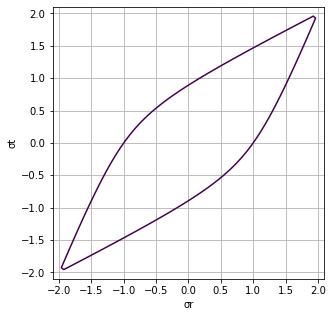

In [5]:
x, y = np.meshgrid(
    np.linspace((-2.1,), (2.1,), 50),
    np.linspace((-2.1,), (2.1,), 50),
)

plt.contour(x, y, f(x, y), [0])
plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

Наша задача - найти максимум и минимум для ${\sigma_r}$ и ${\sigma_t}$, для этого расчитаем частные производные

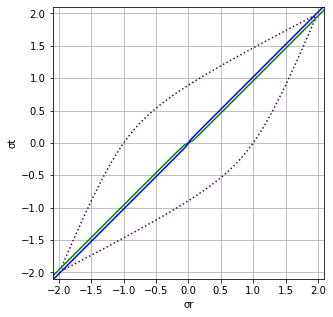

In [6]:
# иллюстрация меода нахождения предельных значений на графике
x, y = np.meshgrid(
    np.linspace((-2.1,), (2.1,), 50),
    np.linspace((-2.1,), (2.1,), 50),
)

plt.contour(
    x, y,
    f(x, y),
    [0],
    linestyles='dotted'
)
plt.contour(
    x, y,
    lambdify((σr, σt), f(σr, σt).diff(σt))(x, y),
    [0],
    colors='g'
)
plt.contour(
    x, y,
    lambdify((σr, σt), f(σr, σt).diff(σr))(x, y),
    [0],
    colors='b'
)

plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

Как видно на графике, предельные значения лежат на пряммой ${\sigma_r = \sigma_t}$

In [7]:
# tol - максимально допустимое отклонение от точного решения
def sigma_limits(tol=math.pow(10, -8)):
    # чисто визуальные оценки для мин/макс значений σr и σt (см. график)
    estimate_for_min, estimate_for_max = (-2.0, -2.0), (2.0, 2.0)
    
    # из графика выше => решение лежит на прямой σr = σt
    def σr_limits_wrapper(σ): return f(σ[0], σ[1]), σ[0] - σ[1]
    sol_for_σr_min = root(σr_limits_wrapper, estimate_for_min, tol=tol).x
    sol_for_σr_max = root(σr_limits_wrapper, estimate_for_max, tol=tol).x
    
    # проверка, что σr = σt 
    assert sol_for_σr_min[0] == sol_for_σr_min[1], sol_for_σr_max[0] == sol_for_σr_max[1]
    
    return sol_for_σr_min[0], sol_for_σr_max[0]
    
    
σ_min, σ_max = sigma_limits()

print("σ_min = {}".format(σ_min))
print("σ_max = {}".format(σ_max))
# %timeit sigma_limits()  # magic-команда для оценки времени выполнения

σ_min = -1.9915638315627207
σ_max = 1.9915638315627207


Вывод графика в координатах $(σ_{r}, σ_{t})$

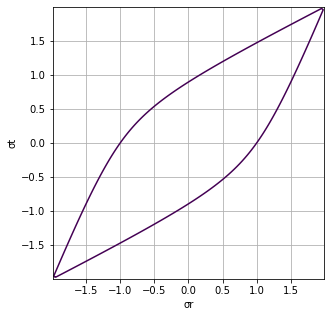

In [8]:
x, y = np.meshgrid(
    np.linspace((σ_min,), (σ_max,), 100),
    np.linspace((σ_min,), (σ_max,), 100),
)

plt.contour(x, y, f(x, y), [0])
plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

## 2. График функции пластичности в координатах $(p_{a}, p_{b})$

Необходимые импорты

In [9]:
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

Задание известных решений для функций напряжений (на границах a и b)

In [10]:
pa, pb = sy.symbols('p_a, p_b', real=True)

fσr_a = -pa
fσt_a = (pa * a**3 - pb * b**3) / (b**3 - a**3) +\
    (a**3 * b**3 * (pa - pb) / ((b**3 - a**3) * a**3)) / 2
fσr_b = -pb
fσt_b = (pa * a**3 - pb * b**3) / (b**3 - a**3) +\
    (a**3 * b**3 * (pa - pb) / ((b**3 - a**3) * b**3)) / 2

fp_a = lambdify((pa, pb), f(fσr_a, fσt_a))
fp_b = lambdify((pa, pb), f(fσr_b, fσt_b))

display(fσr_a, fσt_a, fσr_b, fσt_b)

-p_a

0.512096774193548*p_a - 1.51209677419355*p_b

-p_b

0.0120967741935484*p_a - 1.01209677419355*p_b

Нахождение минимумов и максимумов $p_a$ и $p_b$ (аналогично решению выше)

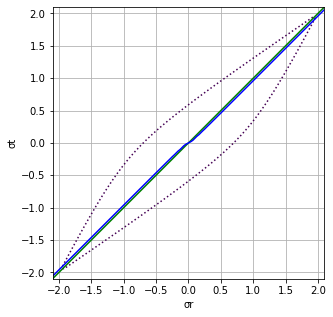

In [11]:
# иллюстрация меода нахождения предельных значений на графике
x, y = np.meshgrid(
    np.linspace((-2.1,), (2.1,), 50),
    np.linspace((-2.1,), (2.1,), 50),
)

plt.contour(x, y, fp_a(x, y), [0], linestyles='dotted')
plt.contour(
    x, y,
    lambdify((pa, pb), f(fσr_a, fσt_a).diff(pa))(x, y),
    [0],
    colors='g'
)
plt.contour(
    x, y,
    lambdify((pa, pb), f(fσr_a, fσt_a).diff(pb))(x, y),
    [0],
    colors='b'
)

plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

In [12]:
# tol - максимально допустимое отклонение от точного решения
def p_limits(tol=math.pow(10, -8)):
    # чисто визуальные оценки для мин/макс значений pa и pb (см. график)
    estimate_for_min, estimate_for_max = (-2.0, -2.0), (2.0, 2.0)
    
    # из графика выше => решение лежит на прямой pa = pb
    def pa_limits_wrapper(p): return fp_a(p[0], p[1]), p[0] - p[1]
    sol_for_pa_min = root(pa_limits_wrapper, estimate_for_min, tol=tol).x
    sol_for_pa_max = root(pa_limits_wrapper, estimate_for_max, tol=tol).x
    
    # проверка, что pa = pb 
    assert sol_for_pa_min[0] == sol_for_pa_min[1], sol_for_pa_max[0] == sol_for_pa_max[1]
    
    return sol_for_pa_min[0], sol_for_pa_max[0]
    
    
p_min, p_max = p_limits()

print("p_min = {}".format(p_min))
print("p_max = {}".format(p_max))

p_min = -1.9915638315627218
p_max = 1.9915638315627218


Получение системы ДУ для нахождения напряжений в пластической области

In [13]:
# Нахождение начальных условий и системы диффуров
# Нахождение системы диффуров (достаточно выполнить 1 раз)
def plastic_eqs():
    r = sy.Symbol("r", real=True)  # расстояние от центра до точки на сфере

    # Задание функций, которые нам нужно найти
    fσr_p = sy.Function("sigma_rp", real=True)(r)
    fσt_p = sy.Function("sigma_tp", real=True)(r)

    # символьные переменные для производных
    d_fσr_p = fσr_p.diff(r)
    d_fσt_p = fσt_p.diff(r)
    
    # уравнение равновесия в пластической зоне
    sol_d_fσr_p = -2 * (fσr_p - fσt_p) / r
    
    # следует из того, что ф-ция пластичности f=1 в пластической зоне => df/dr=0
    # expr - df/dt приводится к функции от (σr(r), σt(r), dσr(r)/dr, dσt(r)/dr)
    expr = sy.Derivative(f(fσr_p, fσt_p)).doit().subs({d_fσr_p: sol_d_fσr_p})
    # далее expr решается относительно d_fσt_p(r)/dr
    sol_d_fσt_p = sy.solve(expr, d_fσt_p)[0]  # здесь всегда одно решение

    # Вывести наши уравнения
    display(sy.Eq(d_fσr_p, sol_d_fσr_p), sy.Eq(d_fσt_p, sol_d_fσt_p))

    # т.о. получили 2 выражения для d_fσr_p и d_fσt_p, зависящих только от r, σr(r) и σt(r)
    # Первый диффур - d_fσr_p
    eq1 = lambdify((r, fσr_p, fσt_p), sol_d_fσr_p)
    # Второй диффур - d_fσt_p
    eq2 = lambdify((r, fσr_p, fσt_p), sol_d_fσt_p)
    
    # SCIPY
    # scipy принимает такой формат для системы ОДУ
    # r - значение независимой переменной r
    # σ - НУ для функций, которые нам нужно найти (σr_p, σt_p)
    def rhs(r, σ):
        σr_p = eq1(r, σ[0], σ[1])
        σt_p = eq2(r, σ[0], σ[1])
        return [σr_p, σt_p]

    return rhs


# Получение системы уравнений
d_fσ_p = plastic_eqs()

Eq(Derivative(sigma_rp(r), r), (-2*sigma_rp(r) + 2*sigma_tp(r))/r)

Eq(Derivative(sigma_tp(r), r), 2.0*(-251058987955041.0*sqrt(0.5*sigma_rp(r)**2 + sigma_tp(r)**2)*sigma_rp(r)*sign(sigma_rp(r) - sigma_tp(r)) + 251058987955041.0*sqrt(0.5*sigma_rp(r)**2 + sigma_tp(r)**2)*sigma_tp(r)*sign(sigma_rp(r) - sigma_tp(r)) - 72474487139159.0*sigma_rp(r)**2 + 72474487139159.0*sigma_rp(r)*sigma_tp(r))/(r*(251058987955041.0*(0.5*sigma_rp(r)**2 + sigma_tp(r)**2)**0.5*sign(sigma_rp(r) - sigma_tp(r)) - 144948974278318.0*sigma_tp(r))))

Функция для расчёта НУ в зависимости от ${p_a}$

In [14]:
# Нахождение начальных условий для пластической области, зарождающейся в a
# первый вариант решения, слишком медленно
# 90.5 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# def initial_conditions(pa_val):
#     σr_a = fσr_a.subs(pa, pa_val)
#     σt_a = sy.solve(f(σr_a, σt), σt)
#     return σr_a, σt_a


# 37.4 µs ± 446 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# т.е. это решение в 2000 раз (!!!) быстрее решения выше
fσr_a_func = lambdify((pa,), fσr_a)
def initial_conditions(pa_val):
    # TODO это нужно как-то исправить, некрасиво
    if pa_val < σ_min: pa_val = σ_min
    if pa_val > σ_max: pa_val = σ_max
        
    σr_a = fσr_a_func(pa_val)
    def f_wrapper(σt): return f(σr_a, σt)
    σt_a_lower = root_scalar(f_wrapper, bracket=[σ_min, σr_a]).root
    σt_a_upper = root_scalar(f_wrapper, bracket=[σr_a, σ_max]).root
    return σr_a, (σt_a_lower, σt_a_upper)


# оценка времени выполнения
# %timeit initial_conditions(p_min)

Функция, возвращающая функцию напряжений в пластической зоне (зарождающейся в $a$) при заданных НУ

In [15]:
# вернёт объект OdeSolution, который можно вызвать как функцию от r
# (a, c1) - границы для значений радиуса r, в (c1, b) - упругая область
# max_step - максимальная длина отрезков, на которые разбивается диапазон (a, b)
def fsigma_p(ics, c1=b, max_step=0.1):
    σ_p = solve_ivp(d_fσ_p, (a, c1), ics, max_step=max_step, method="RK45", dense_output=True).sol
    return σ_p

# проверка
display(fsigma_p([-0.2, 0.76])(np.linspace(a, b, 9)))

array([[-0.2       ,  0.47306158,  0.82976857,  1.0494636 ,  1.19834673,
         1.30595653,  1.38741001,  1.45124052,  1.5026297 ],
       [ 0.76      ,  1.17436237,  1.37368768,  1.49313876,  1.57308206,
         1.63045274,  1.67367913,  1.70744456,  1.73456436]])

Предобработка для функции напряжений в упругой зоне

In [16]:
def preprocess_fsigma_e():
    r = sy.Symbol("r", real=True)  # расстояние от центра до точки на сфере

    # формулы для упругой зоны
    A, B = sy.symbols("A, B", real=True)  # неизвестные константы
    fσr_e = -2 * A / r**3 + B
    fσt_e = A / r**3 + B
    display(fσr_e, fσt_e)
    
    # A, B находим из начальных условий в a
    σr_p, σt_p = sy.symbols("σr_p, σt_p", real=True)
    eq1, eq2 = fσr_e - σr_p, fσt_e - σt_p
    constants = sy.solve([eq1, eq2], (A, B))
#     constants = sy.solve([eq1.subs(r, a), eq2.subs(r, a)], (A, B))
#     display(constants)

#     fσr_e, fσt_e = fσr_e.subs(constants), fσt_e.subs(constants)
#     display(fσr_e, fσt_e)

    def fsigma_e(ics, c1=b):
        σ_p = fsigma_p(ics, c1=c1)(c1)
        const_val = {k: v.subs({r: c1, σr_p: σ_p[0], σt_p: σ_p[1]}) \
                     for k, v in constants.items()}
        σr_e, σt_e = fσr_e.subs(const_val), fσt_e.subs(const_val)
        return lambdify((r,), σr_e), lambdify((r,), σt_e)
    
    return fsigma_e


# возвращает функции σr(r) и σt(r)
fsigma_e = preprocess_fsigma_e()

-2*A/r**3 + B

A/r**3 + B

Расчёт функции напряжений при фиксированных $p_a$ и границе зарождения пластической области $c_1$

In [17]:
# upper определяет, возвращать решение с "верхней" или с "нижней" дуги функции пластичности
def fsigma(pa_val, c1=b, upper=True):
    if not (p_min <= pa_val <= p_max):
        raise ValueError("Значение pa должно быть в диапазоне (p_min, p_max)")
        
    ics = initial_conditions(pa_val)
    ics = ics[0], max(ics[1]) if upper else min(ics[1])

    # fσ_p(r)[0] - массив значений σr(r), fσ_p(r)[1] - массив значений σt(r)
    fσ_p = fsigma_p(ics, c1=c1)
    
    # fσr(r) и fσt(r)
    fσr_e, fσt_e = fsigma_e(ics, c1=c1)
    def fσ_e(r):
        r = np.array(r, ndmin=1)
        if len(r) == 1:
            σr_e, σt_e = fσr_e(r[0]), fσt_e(r[0])
        else:
            σr_e, σt_e = list(map(fσr_e, r)), list(map(fσt_e, r))
        return np.array([σr_e, σt_e])
    
    def fσ(r): return fσ_p(r) if r < c1 else fσ_e(r)
    
    return fσ, fσ_p, fσ_e


# проверка
display(fsigma(0.5)[0](0.7))
display(fsigma(0.2, c1=a)[2](np.linspace(a, b, 9)))

array([1.20347617, 1.57712204])

array([[-0.2       ,  0.25094796,  0.36071819,  0.39980825,  0.41708668,
         0.42587453,  0.43080796,  0.43378846,  0.43569422],
       [ 0.76123118,  0.5357572 ,  0.48087208,  0.46132705,  0.45268784,
         0.44829391,  0.4458272 ,  0.44433695,  0.44338407]])

Нахождение ${p_b}$ по заданному ${p_a}$

In [18]:
# возвращает пару значений pb
def fpb(pa_val, c1=b):
    ics = initial_conditions(pa_val)
    ics_upper = ics[0], max(ics[1])
    ics_lower = ics[0], min(ics[1])
    fσr_e_upper, _ = fsigma_e(ics_upper, c1=c1)
    fσr_e_lower, _ = fsigma_e(ics_lower, c1=c1)
    pb = -fσr_e_upper(b), -fσr_e_lower(b)
    return pb


# проверка
display(fpb(0))

(-1.552358833249121, 1.552358833249121)

Вывод графика в координатах $(p_a, p_b)$

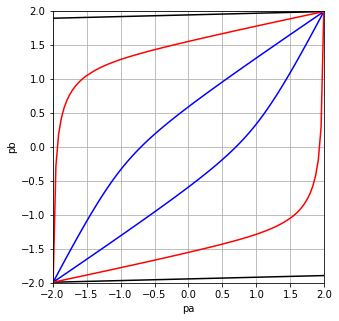

In [19]:
pcount = 100
x, y = np.meshgrid(
    np.linspace(math.floor(p_min), math.ceil(p_max), pcount),
    np.linspace(math.floor(p_min), math.ceil(p_max), pcount)
)

# f_a
plt.contour(x, y,
    fp_a(x, y),
    [0],
    colors='b'
)
# f_b
plt.contour(
    x, y,
    fp_b(x, y),
    [0],
    colors='k'
)

x_ = np.linspace(p_min, p_max, pcount)
y_ = list(map(fpb, x_))
plt.plot(x_, y_,color='r')

plt.xlabel("pa")
plt.ylabel("pb")
plt.axis("square")
plt.grid()
plt.show()

На одном графике представлены функции пластичности для различных значений упругопластической границы $c_1$

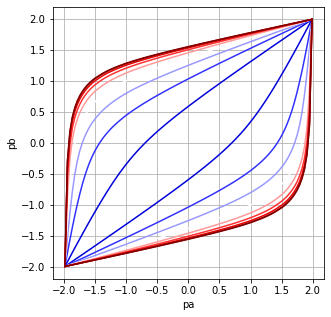

In [20]:
from matplotlib import cm 

def show():
    cmap = cm.get_cmap('seismic') # для градиента
    pcount = 100

    pa_list = np.linspace(p_min, p_max, pcount)
    c1_list = np.linspace(a, b, 9)

    for c1 in c1_list:
        pb_list = list(map(lambda pa: fpb(pa, c1=c1), pa_list))
        plt.plot(pa_list, pb_list, color=cmap(c1))

    plt.xlabel("pa")
    plt.ylabel("pb")
    plt.axis("square")
    plt.grid()
    plt.show()

show()
# %load_ext memory_profiler
# %memit show()

## 3. Графики зависимостей $\sigma_r(r)$, $\sigma_t(r)$ и функции пластичности при фиксированных $p_a, p_b$

Функция, которая находит упругопластическую границу при заданном давлении и возвращает функции напряжений

In [21]:
def fsigma_of_pa_pb(pa_val, pb_val, pcount=100):
    if not (p_min <= pa_val <= p_max and p_min <= pb_val <= p_max):
        raise ValueError("Значения pa и pb должны быть в диапазоне (p_min, p_max)")
        
    upper = pb_val <= pa_val
    fσ, fσ_p, fσ_e = fsigma(pa_val, upper=upper)
    
    if pb_val > pa_val and -fσ_p(b)[0] < pb_val or pb_val < pa_val and -fσ_p(b)[0] > pb_val:
        raise ValueError("Для данной конфигурации параметров решения нет")
        
    def pb_of_c1(c1):
        pb_sol = fpb(pa_val, c1=c1)
        return pb_sol[0] if upper else pb_sol[1]
    
    c1_list = np.linspace(a, b, pcount)
    pb_list = list(map(pb_of_c1, c1_list))
#     display(pb_list)
    
    pb_val = min(pb_list, key=lambda pb_sol: abs(pb_sol - pb_val))
    c1 = c1_list[pb_list.index(pb_val)]
    
    fσ, fσ_p, fσ_e = fsigma(pa_val, c1)
    
    return fσ, fσ_p, fσ_e, pb_val, c1


pa_val, pb_val = 0.2, -1.3
fσ, fσ_p, fσ_e, pb_val, c1 = fsigma_of_pa_pb(pa_val, pb_val)
print("pb = {}, c1 = {}".format(pb_val, c1))

pb = -1.3001542248418085, c1 = 0.4909090909090909


Вывод графиков напряжений $\sigma_r(r)$, $\sigma_t(r)$

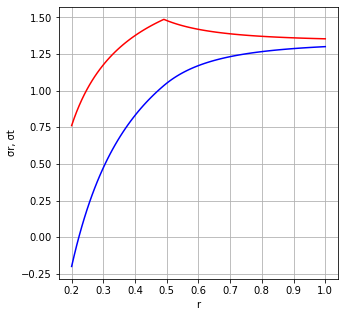

In [22]:
# компоненты функции напряжений
def fσr(r): return fσ(r)[0] 
def fσt(r): return fσ(r)[1] 

pcount = 100
r_list = np.linspace(a, b, pcount)
σr_list = list(map(fσr, r_list))
σt_list = list(map(fσt, r_list))

plt.plot(r_list, σr_list, color='b')
plt.plot(r_list, σt_list, color='r')

plt.xlabel("r")
plt.ylabel("σr, σt")
plt.grid()
plt.show()

Переход пластической зоны (синий) в упругую (зелёный) на графике функции пластичности

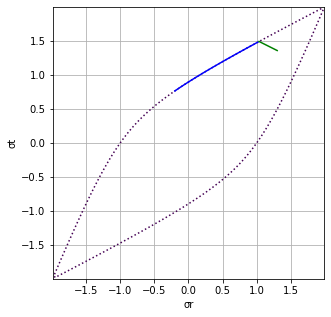

In [23]:
σr_p_list = list(map(fσr, filter(lambda r: r < c1, r_list)))
σt_p_list = list(map(fσt, filter(lambda r: r < c1, r_list)))
plt.plot(σr_p_list, σt_p_list, color='b')

σr_e_list = list(map(fσr, filter(lambda r: r >= c1, r_list)))
σt_e_list = list(map(fσt, filter(lambda r: r >= c1, r_list)))
plt.plot(σr_e_list, σt_e_list, color='g')

x_dot, y_dot = np.meshgrid(
    np.linspace((σ_min,), (σ_max,), pcount),
    np.linspace((σ_min,), (σ_max,), pcount),
)
plt.contour(
    x_dot, y_dot,
    f(x_dot, y_dot),
    [0],
    linestyles='dotted'
)

plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

Время, потраченное на выполнение всей программы

In [24]:
display(time.time() - start_time)

17.43365454673767